In [15]:
cd ..

C:\Users\688228hh


In [16]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 11.0,
    'theta': 0.04,
    'xi': 0.9
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] - params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 0, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

0.07


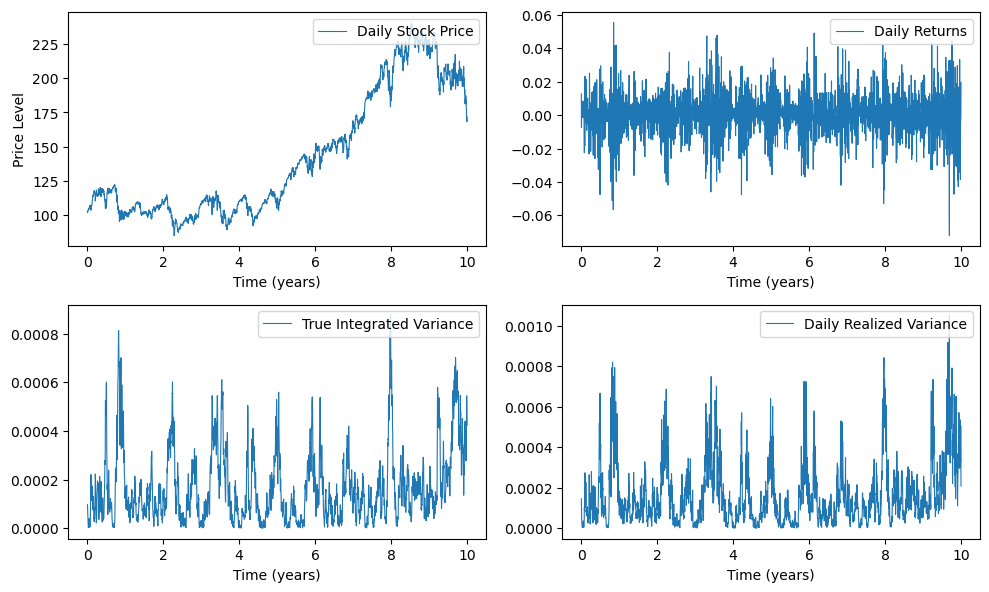

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [19]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [20]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.020501
theta: 0.000108
xi: 0.002442
mu: 0.000494
sigma: 0.000232
Negative Log-Likelihood: -14058.201110
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [0.0205011  0.00010766 0.00244174 0.00049354 0.00023249]


### Both - Corr

In [21]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.005656
theta: 0.000472
xi: 0.002709
mu: 0.001015
sigma: 0.000001
rho: -0.620089
Negative Log-Likelihood: -14110.083288
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 5.65580477e-03  4.72043961e-04  2.70943150e-03  1.01477453e-03
  1.00000000e-06 -6.20089335e-01]


### Return

In [22]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.027648
theta: 0.000148
xi: 0.011125
mu: -0.000185
Negative Log-Likelihood: -3896.116267
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 0.0276481   0.00014805  0.01112503 -0.00018525]


### Return - Corr

In [23]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 1.007247
theta: 0.000145
xi: 0.022835
mu: 0.000351
rho: -0.000024
Negative Log-Likelihood: -3781.161666
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 1.00724691e+00  1.44556528e-04  2.28352704e-02  3.50911978e-04
 -2.41969086e-05]


### RV

In [24]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.033023
theta: 0.000136
xi: 0.003803
sigma: 0.002249
Negative Log-Likelihood: -10808.489914
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.03302314 0.00013581 0.00380304 0.00224943]


### PF

In [25]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.2, 0.2),    # mu
    (1, 10),        # kappa
    (0.02, 0.1),    # theta
    (0.05, 0.8),    # xi
    (-1, 0),        # rho
    V0              # v0
]

V_pf_train, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
V_pf_train_daily = V_pf_train / 252

resampling since: 1078.5195933107802
resampling since: 1579.5336299413136
resampling since: 1235.9417694679253
resampling since: 446.4404052350526
resampling since: 2161.0143559584512
resampling since: 3430.2082788527164
resampling since: 1802.6420977301857
resampling since: 1538.7156919820848
resampling since: 3393.106368346279
resampling since: 2161.6877278822167
resampling since: 996.8251498140535
resampling since: 2880.792794313602
resampling since: 2695.436184265789
resampling since: 2662.3753688783286
resampling since: 2824.6608084835884
resampling since: 1701.6069223958966
resampling since: 683.7624802685582
resampling since: 148.37464432818055
resampling since: 2745.862982208135
resampling since: 630.1926979307252
resampling since: 3147.799162617575
resampling since: 3372.5218822633096
resampling since: 2996.056806103684
resampling since: 3445.6492154258044
resampling since: 490.0932630015472
resampling since: 2799.154636308879
resampling since: 3448.9932287999145
resampling si

In [26]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

param_bounds_test = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))
param_bounds_test.append(V_pf_train[-1])

V_pf_test, _ = pf_heston_test.filter(param_bounds_test, predict_obs=False)
V_pf_test_daily = V_pf_test / 252

resampling since: 3190.1589194806393
resampling since: 3344.5989634275284
resampling since: 3255.7850571226954
resampling since: 3253.538855265279
resampling since: 2972.969049364164
resampling since: 2818.065277585795
resampling since: 3441.7933922361467
resampling since: 2754.3848205168138
resampling since: 3486.4692118721746
resampling since: 3324.622484724148
resampling since: 2705.8089839648474
resampling since: 473.67766022495886
resampling since: 3274.2680335656078
resampling since: 3403.5184035572856
resampling since: 3274.097569885542
resampling since: 2928.218874915361
resampling since: 3332.807907128904
resampling since: 3286.0262195946184
resampling since: 3133.1262726260916
resampling since: 1818.1038271329112
resampling since: 2452.2636651913754
resampling since: 2634.6896757913
resampling since: 3115.3560133241863
resampling since: 3056.4403903257285
resampling since: 3247.81997383434
resampling since: 3130.6507410614713
resampling since: 2022.2158292565587
resampling si

## Plot

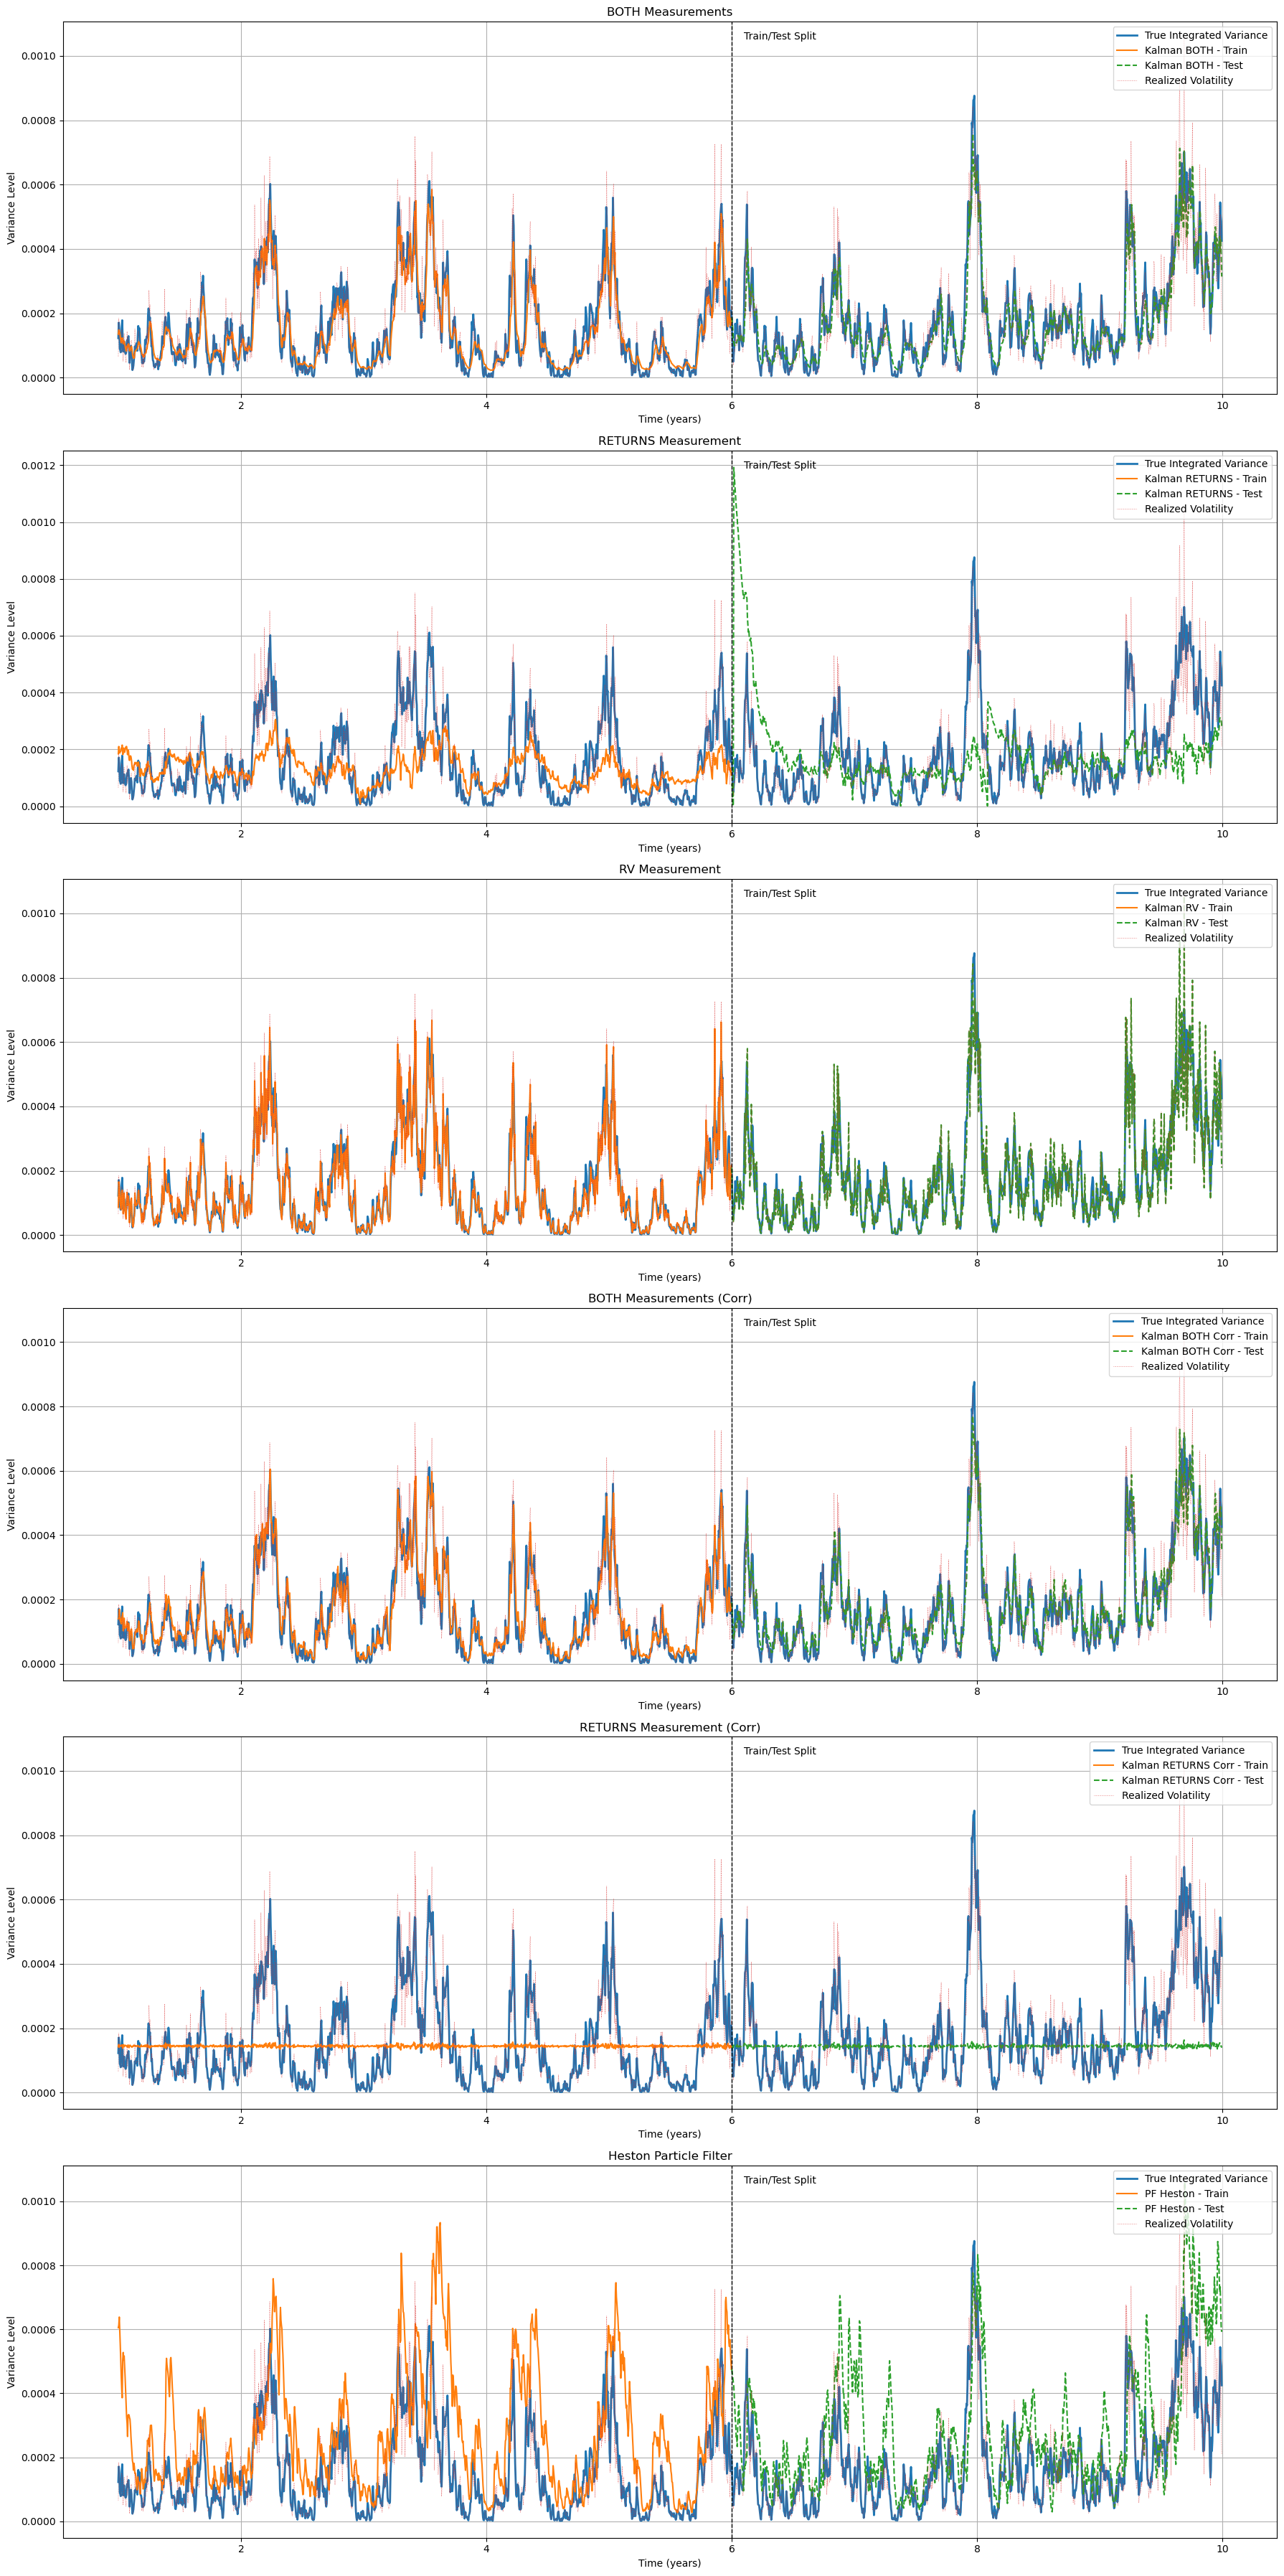

In [28]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt'], V_pf_train_daily]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr, V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252,
    save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\high_swing_fast_rev.png"
)

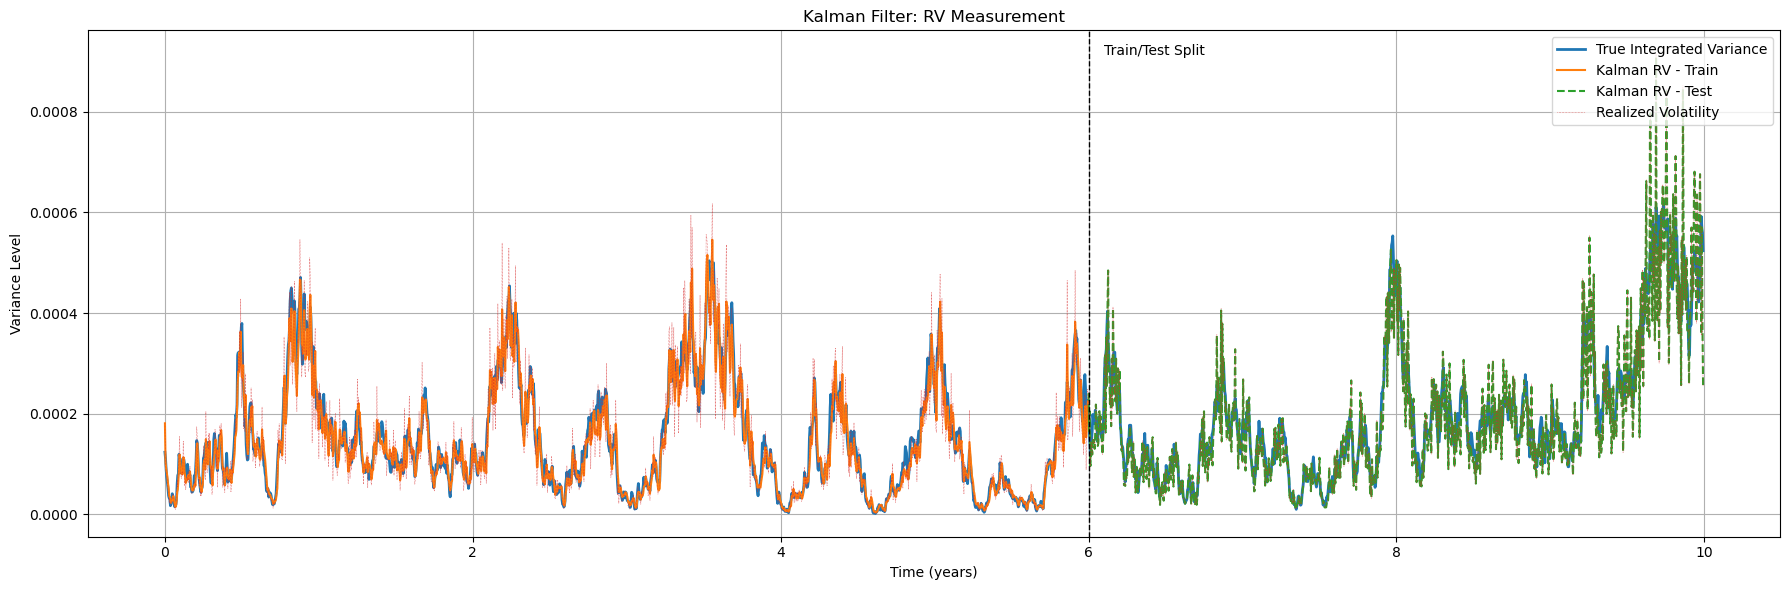

In-Sample RMSE (RV Measurement): 0.000026
Out-of-Sample RMSE (RV Measurement): 0.000055


(2.5867919148173176e-05, 5.4892072600495645e-05)

In [14]:
Utility.plot_filter_result(
    plot_index=2,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034
